In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
def remove_slash_name(_df):
    df = _df.copy()
    df['Player'] = df['Player'].apply(lambda row: row.split('\\')[0])
    return df

def remove_rk(_df):
    df = _df.copy()
    return df.drop(['Rk'], axis=1)

def remove_team(_df):
    df = _df.copy()
    return df.drop(['Tm'], axis=1)

def remove_age(_df):
    df = _df.copy()
    return df.drop(['Age'], axis=1)

def remove_game(_df):
    df = _df.copy()
    return df.drop(['G'], axis=1)   

def remove_game_started(_df):
    df = _df.copy()
    return df.drop(['GS'], axis=1)   

def remove_min(_df):
    df = _df.copy()
    return df.drop(['MP'], axis=1)    

def extract_name_position(_df):
    df = _df.copy()
    return _df.drop(['Pos','Player', 'Tm'], axis=1), _df[['Player', 'Pos', 'Tm']]
    

def remove_nan(_df):
    df = _df.copy()
    return df.dropna(axis=1, how='all').fillna(0)

def normalize_cols(_df):
    x = _df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns=_df.columns)
    return df

def remove_under_threshold(_df, th = 0.0080):
    """Remove cols with variance under a certain threshold"""
    df = _df.copy()
    cols_true_false = [v <= th for v in df.var().values]
    return df.drop(np.extract(cols_true_false, df.columns), axis=1)
    

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
    n_clusters=10, n_init=500, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=2e-05, verbose=0)


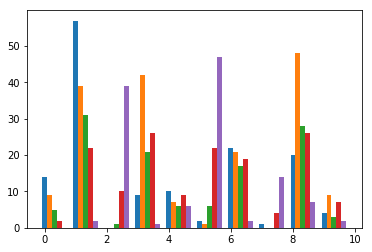

,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,...,AST,STL,BLK,TOV,PF,PTS,Player,Pos,Tm,preds
0,0.374684,0.338000,0.809,0.0415,0.009,0.086379,0.081395,0.058583,0.105691,0.060811,...,0.056075,0.208333,0.074074,0.10,0.425,0.146814,Alex Abrines,SG,OKC,8
1,0.345992,0.252667,0.833,0.2780,0.027,0.222591,0.218992,0.111717,0.032520,0.182432,...,0.074766,0.041667,0.148148,0.08,0.600,0.047091,Quincy Acy,PF,PHO,8


In [116]:
def silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return sc(X, cluster_labels)

def create_cluster(_df, pos):
    df = _df.copy()
    
    models = []
    for n_c in range(10,20):
        for tol in [0.0001, 0.00005, 0.00002, 0.00001, 0.000001]:
            models.append(KMeans(n_clusters=n_c, n_jobs=-1,n_init=500, max_iter=10000, tol=tol))
        models.append(AgglomerativeClustering(n_clusters=n_c))
        
    best_model = None
    best_score = 0
    
    for i in models:
        preds = i.fit_predict(df.values)
        score = silhouette_score(df.values,preds)
        if score > best_score:
            best_model = i
            best_score = score
#         print(f" {score}, {i}")
    
    return best_model, best_model.n_clusters

def plot_model(_df, pos, model):
    df = _df.copy()
    preds = model.fit_predict(df.values)
        
    df['Player'] = pos['Player']
    df['Pos'] = pos['Pos']
    df['Tm'] = pos['Tm']
    df['preds'] = preds


    vals = []
    for p in ['PG','SG','SF','PF','C']:
        sub_vals = []
        for c in range(NB_CLUSTERS):
            sub_vals.append(df.loc[(df["Pos"] == p) & (df["preds"] == c)].shape[0])
        vals.append(sub_vals)

    vals = np.asarray(vals)
    data = vals

    color_list = ['b', 'g', 'r', 'y', 'orange']
    gap = .8 / len(data)
    for i, row in enumerate(data):
        X = np.arange(len(row))
        plt.bar(X + i * gap, row,
            width = gap)

    plt.show()
    return df

df = pd.read_csv('merge_stats.csv')

df = remove_rk(remove_slash_name(df))
# df = remove_age(remove_team(df))
df = remove_age(df)
df = remove_game(remove_min(df))
df = remove_game_started(df)
df, pos = extract_name_position(df)

df = remove_nan(df)
df = normalize_cols(df)

model, NB_CLUSTERS = create_cluster(df,pos)

print(model)

res_df = plot_model(df, pos, model)
res_df[:2]

In [117]:
mean_df = pd.DataFrame(columns=df.columns)
for i in range(NB_CLUSTERS):
    c_df = res_df.loc[res_df['preds'] == i][df.columns]
    mean_df.loc[i] = c_df[df.columns].mean()

print("best cluster for each stats")
for k, vals in mean_df.to_dict().items():
    cluster = max(vals, key=vals.get)
    print(f"{k} -> {cluster} ")

best cluster for each stats
PER -> 7 
TS% -> 9 
3PAr -> 3 
FTr -> 7 
ORB% -> 7 
DRB% -> 7 
TRB% -> 7 
AST% -> 0 
STL% -> 0 
BLK% -> 2 
TOV% -> 5 
USG% -> 0 
OWS -> 7 
DWS -> 7 
WS -> 7 
WS/48 -> 7 
OBPM -> 0 
DBPM -> 7 
BPM -> 7 
VORP -> 7 
FG -> 0 
FGA -> 0 
FG% -> 9 
3P -> 0 
3PA -> 0 
3P% -> 9 
2P -> 7 
2PA -> 7 
2P% -> 2 
eFG% -> 9 
FT -> 0 
FTA -> 0 
FT% -> 0 
ORB -> 7 
DRB -> 7 
TRB -> 7 
AST -> 0 
STL -> 0 
BLK -> 7 
TOV -> 0 
PF -> 7 
PTS -> 0 


In [118]:
df_teams = pd.read_csv('teams_stats.csv')
cols = ['Tm'] + ['W'] + ['L'] + ['C_'+str(i) for i in range(NB_CLUSTERS)]
a = pd.DataFrame(columns=cols)

for tm in np.sort(df_teams['Team'].values):
    tm_players = res_df.loc[res_df['Tm'] == tm]
    tm_stats = df_teams.loc[df_teams['Team'] == tm]
    
    count_by_preds = pd.Series(index=[str(i) for i in range(NB_CLUSTERS)]).fillna(0)
    for key, val in tm_players.groupby(['preds']).size().to_dict().items():
        count_by_preds[key] = val
    
    win_loss = tm_stats[['Team', 'W', 'L']].values
    
    a = a.append(pd.Series(np.append(win_loss, count_by_preds), index=cols), ignore_index=True)

In [119]:
_a = a.copy()
_a['W10'] = _a['W'].apply(lambda x: int(x/10))
_a.groupby('W10').mean()

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9
W10,,,,,,,,,,
1,0.333333,8.000000,2.333333,1.666667,2.000000,1.666667,4.000000,0.333333,4.333333,0.00
2,1.000000,5.000000,1.500000,2.000000,1.500000,2.500000,4.000000,0.500000,3.500000,0.50
3,1.000000,4.555556,1.777778,2.888889,1.333333,2.111111,3.000000,0.444444,3.222222,1.00
4,1.000000,2.375000,1.000000,2.875000,1.125000,2.875000,2.125000,0.625000,3.500000,0.75
5,1.285714,4.285714,1.428571,3.142857,0.714286,2.142857,1.142857,1.000000,4.142857,1.00
6,1.000000,5.000000,0.000000,3.000000,2.000000,1.000000,2.000000,1.000000,8.000000,1.00


In [146]:
a = a.sort_values(['W', 'L'], ascending=False)
best_teams_roster = a[:3].mean().round().values
my_team_players = []


for i in range(NB_CLUSTERS):
    
    players = res_df.loc[res_df['preds'] == i][['Player','Tm']].values
    players = ["{}_{}".format(i[0],i[1]) for i in players]
    print(np.random.choice(players,int(best_teams_roster[i]), replace=False))

['Kawhi Leonard_TOR' 'LeBron James_LAL']
['Frank Jackson_NOP' 'Sam Dekker_CLE' 'Dwayne Bacon_CHO'
 'Miles Bridges_CHO']
['Thaddeus Young_IND' 'Al Horford_BOS']
['Davis Bertans_SAS' 'Damyean Dotson_NYK']
['Ike Anigbogu_IND']
['Kevon Looney_GSW' 'Alan Williams_BRK' 'Marcin Gortat_LAC']
['CJ McCollum_POR']
['Steven Adams_OKC']
['Kyle Korver_CLE' 'Courtney Lee_DAL' 'Mike Scott_LAC' 'Nik Stauskas_TOT'
 'Milos Teodosic_LAC' 'Marquese Chriss_HOU']
['Eric Moreland_TOR']


In [129]:
a = a.sort_values(['W','L'], ascending=True)
worst_teams_roster = a[:3].mean().round().values
my_team_players = []

for i in range(NB_CLUSTERS):
    players = res_df.loc[res_df['preds'] == i][['Player','Tm']].values
    players = ["{}_{}".format(i[0],i[1]) for i in players]
    print(np.random.choice(players,int(worst_teams_roster[i]), replace=False))

[]
['Quinn Cook_GSW' 'Dragan Bender_PHO' 'Wayne Selden_CHI'
 'Jonathon Simmons_TOT' 'Zhaire Smith_PHI' 'Yogi Ferrell_SAC'
 'Marquese Chriss_TOT' 'Frank Jackson_NOP']
['Enes Kanter_TOT' 'Tyler Zeller_MEM']
['Stanley Johnson_DET' 'Jae Crowder_UTA']
['Tyler Davis_OKC' 'Tyler Ulis_CHI']
['Bismack Biyombo_CHO' 'Miles Plumlee_ATL']
['Harrison Barnes_SAC' 'Nikola Mirotic_NOP' 'Jeremy Lamb_CHO'
 'Kevin Knox_NYK']
[]
['Wesley Johnson_WAS' 'Abdel Nader_OKC' 'Lonnie Walker_SAS'
 'Wesley Johnson_TOT']
[]
